In [2]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import joblib

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Download the dataset

In [3]:
# os.environ['KAGGLE_USERNAME'] = "pandeyabhishek79038"
# os.environ['KAGGLE_KEY'] = "3423842a66eaea9bc8933fa14d73ac32"
# Load the dataset and generate the response. 

## 1. RAVDESS Dataset

In [4]:
# !kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

In [5]:
# !unzip -q ravdess-emotional-speech-audio.zip -d ravdess_data

In [6]:
for dirname, _, filenames in os.walk('/kaggle/input/'):
    print(dirname)

/kaggle/input/
/kaggle/input/toronto-emotional-speech-set-tess
/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data
/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear
/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_angry
/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Fear
/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_disgust
/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_neutral
/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_angry
/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Sad
/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_disgust
/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional s

In [8]:
RAVDESS_PATH = '/kaggle/input/ravdess-emotional-speech-audio'
print(os.listdir(RAVDESS_PATH))

['Actor_02', 'Actor_17', 'Actor_05', 'Actor_16', 'Actor_21', 'Actor_01', 'Actor_11', 'Actor_20', 'Actor_08', 'Actor_15', 'Actor_06', 'Actor_12', 'Actor_23', 'Actor_24', 'Actor_22', 'Actor_04', 'Actor_19', 'Actor_10', 'Actor_09', 'audio_speech_actors_01-24', 'Actor_14', 'Actor_03', 'Actor_13', 'Actor_18', 'Actor_07']


In [9]:
file_emotion = []
file_path = []

for dir in os.listdir(RAVDESS_PATH):
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor_folder = os.path.join(RAVDESS_PATH, dir)

    if not os.path.isdir(actor_folder) or not dir.startswith("Actor_"):
        continue

    for file in os.listdir(actor_folder):
        if not file.endswith('.wav'):
            continue

        try:
            part = file.split('.')[0].split('-')
            if len(part) != 7:
                continue  # skip malformed files
            emotion = int(part[2])
            # third part in each file represents the emotion associated to that file.
            file_emotion.append(emotion)
            file_path.append(os.path.join(actor_folder, file))
        except Exception as e:
            print(f"Skipping file {file}: {e}")

# Create DataFrame
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Map integers to labels
emotion_map = {
    1: 'neutral',
    2: 'calm',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprise'
}

# changing integers to actual emotions.
Ravdess_df['Emotions'] = Ravdess_df['Emotions'].replace(emotion_map)

# Displaying top 5 records
Ravdess_df.head()

Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/A...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/A...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/A...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/A...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/A...

## 2. TESS DATASET

In [10]:
TESS_DATASET_PATH = r'/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data'

tess_directory_list = os.listdir(TESS_DATASET_PATH)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    sub_dir = os.path.join(TESS_DATASET_PATH, dir)
    if not os.path.isdir(sub_dir):
        continue

    for file in os.listdir(sub_dir):
        if not file.endswith('.wav'):
            continue

        try:
            part = file.split('.')[0].split('_')[2]
            if part == 'ps':  # TESS sometimes labels 'ps' for 'surprise'
                file_emotion.append('surprise')
            else:
                file_emotion.append(part)
            file_path.append(os.path.join(sub_dir, file))
        except IndexError:
            print(f"Skipping: {file}")

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)

Tess_df.head()

Emotions                                               Path
0     fear  /kaggle/input/toronto-emotional-speech-set-tes...
1     fear  /kaggle/input/toronto-emotional-speech-set-tes...
2     fear  /kaggle/input/toronto-emotional-speech-set-tes...
3     fear  /kaggle/input/toronto-emotional-speech-set-tes...
4     fear  /kaggle/input/toronto-emotional-speech-set-tes...

## 3. CREMA-D DATASET

In [11]:
SAVEE_PATH = '/kaggle/input/savee-database/AudioData/'

emotion_map = {
    'a': 'angry',
    'd': 'disgust',
    'f': 'fear',
    'h': 'happy',
    'n': 'neutral',
    'sa': 'sad',
    'su': 'surprise'
}

file_emotion = []
file_path = []

for root, dirs, files in os.walk(SAVEE_PATH):
    for file in files:
        if file.endswith('.wav'):
            filename = file.split('.')[0].lower()
            
            # Handle 2-letter prefixes
            if filename.startswith('sa'):
                emotion = 'sa'
            elif filename.startswith('su'):
                emotion = 'su'
            else:
                emotion = filename[0]

            if emotion in emotion_map:
                file_emotion.append(emotion_map[emotion])
                file_path.append(os.path.join(root, file))
            else:
                print(f"Skipping unknown emotion code in file: {file}")

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)

Savee_df.head()

Empty DataFrame
Columns: [Emotions, Path]
Index: []

## Combining all the dataset.

In [12]:
# creating Dataframe using all the 4 dataframes we created so far.
data_df = pd.concat([Ravdess_df, Tess_df], axis = 0)
data_df.to_csv("data_df.csv",index=False)
data_df.head()

Emotions                                               Path
0  surprise  /kaggle/input/ravdess-emotional-speech-audio/A...
1   neutral  /kaggle/input/ravdess-emotional-speech-audio/A...
2   disgust  /kaggle/input/ravdess-emotional-speech-audio/A...
3   disgust  /kaggle/input/ravdess-emotional-speech-audio/A...
4   neutral  /kaggle/input/ravdess-emotional-speech-audio/A...

In [13]:
# data_df.info()

## Exploratory Data Analysis

### Audio Visualization
* Waveform plots
* Spectrograms
* Mel Spectrograms
* MFCCs (Mel Frequency Cepstral Coefficients)
* Save these visualizations for at least 2 samples per emotion

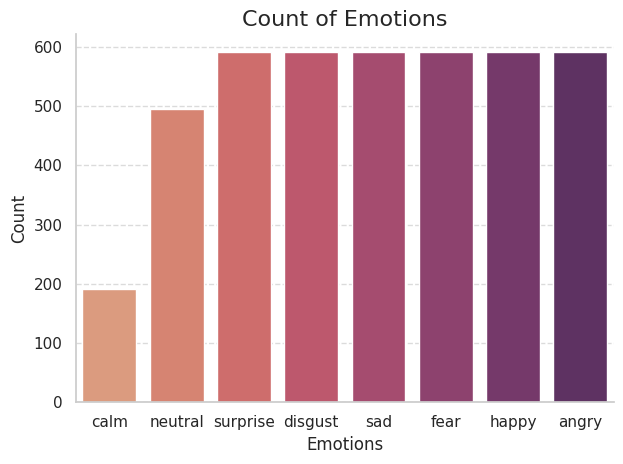

In [14]:
# plot the count of each emotions in our dataset.
# Sort emotions by count (ascending order)
order = data_df['Emotions'].value_counts().sort_values().index

# grid layout
sns.set(style="whitegrid")

plt.title('Count of Emotions', size=16)
sns.countplot(x='Emotions', data=data_df, order=order, palette="flare")
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
# sns.despine(top=True, right=True, left=False, bottom=False)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Show grid on y-axis
sns.despine(top=True, right=True)

plt.tight_layout()
plt.show()

In [15]:
# 1. Waveform
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

In [16]:
# 2. Spectrogram
def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [17]:
# 3. Mel Spectrogram
def create_mel_spectrogram(data, sr, e):
    S = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(12, 3))
    plt.title(f'Mel Spectrogram for audio with {e} emotion', size=15)
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()

In [18]:
# 4. MFCC
def create_mfcc(data, sr, e):
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13)
    plt.figure(figsize=(12, 3))
    plt.title(f'MFCC for audio with {e} emotion', size=15)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

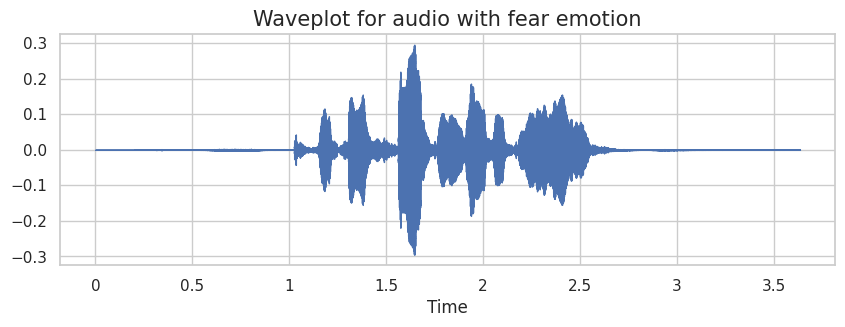

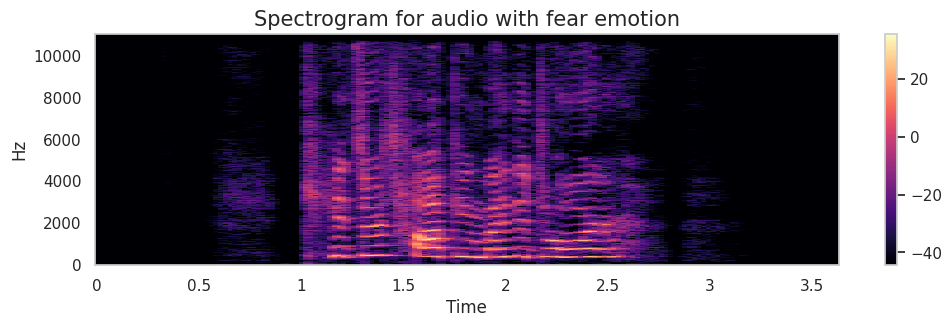

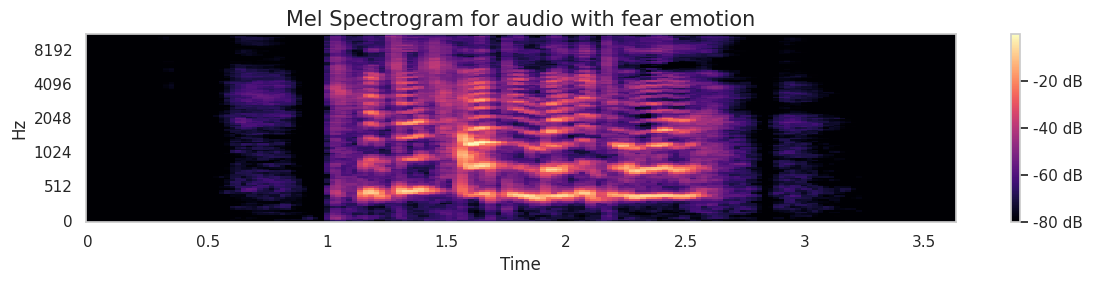

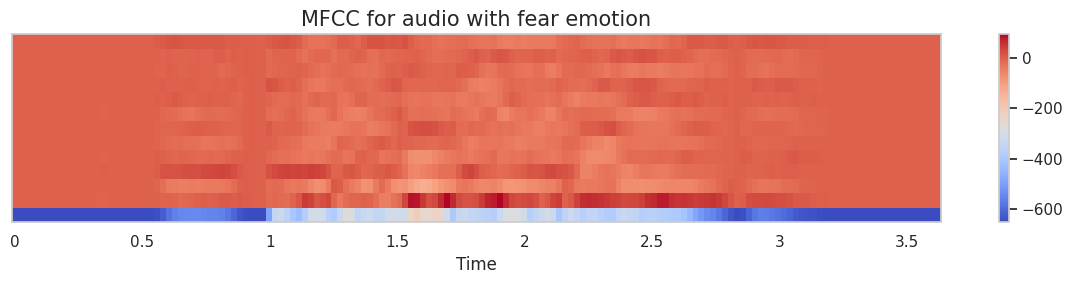

In [19]:
# Emotion : Fear
emotion='fear'
path = np.array(data_df.Path[data_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mel_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

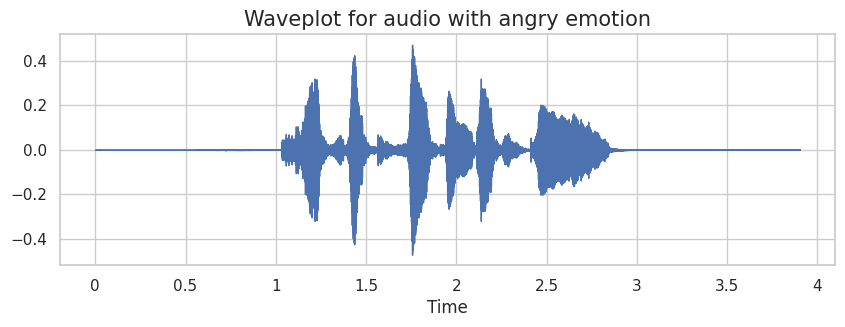

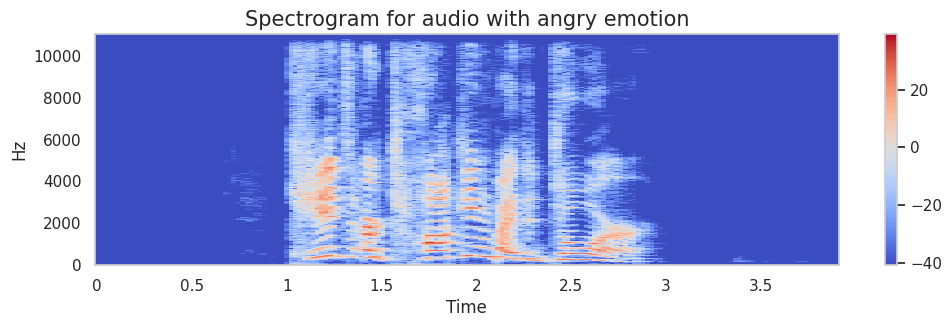

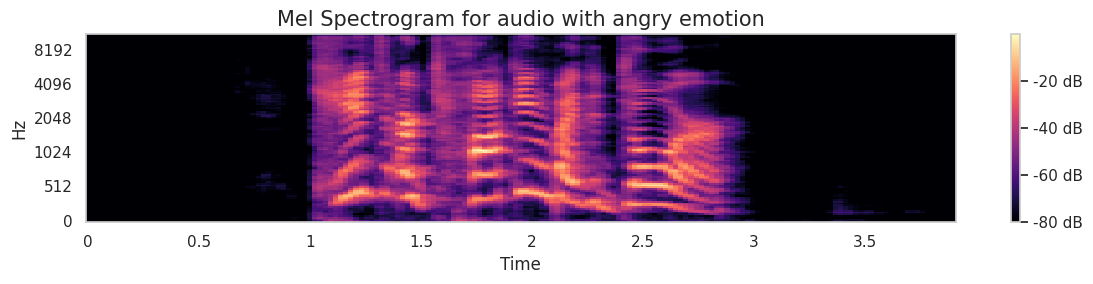

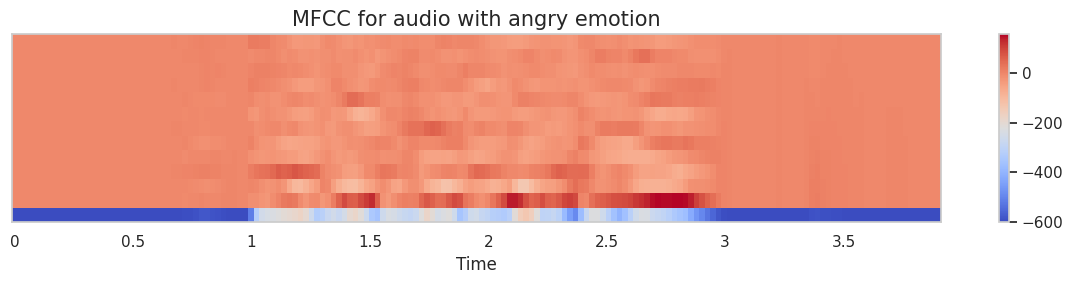

In [20]:
# Emotion : Angry
emotion='angry'
path = np.array(data_df.Path[data_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mel_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

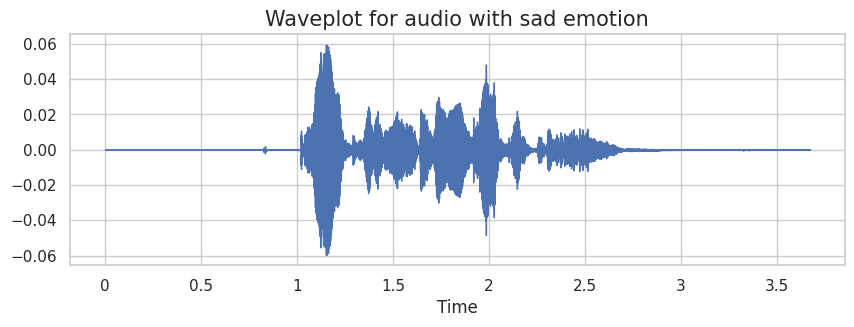

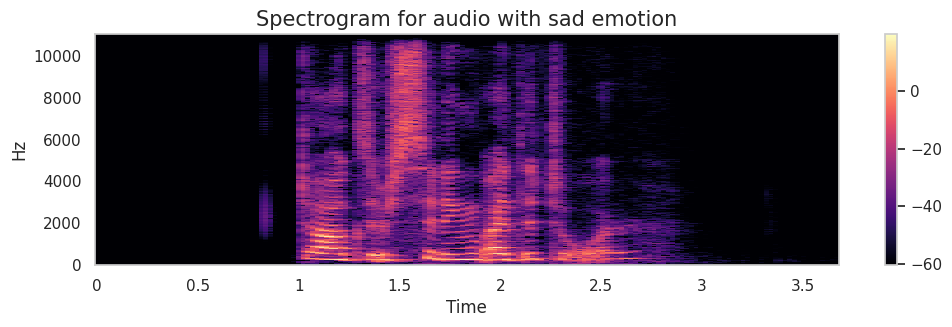

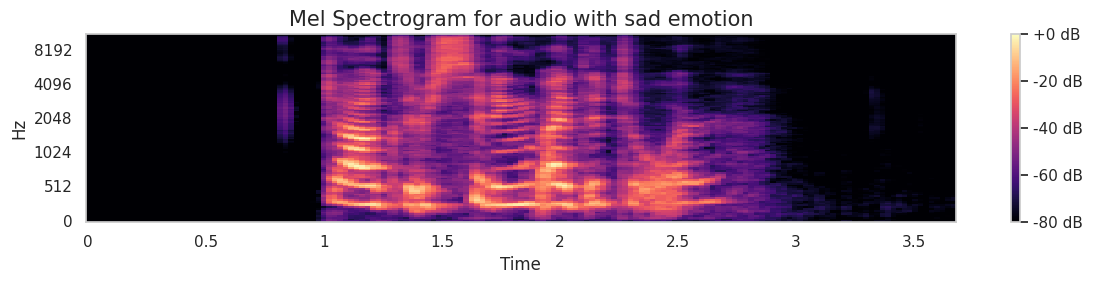

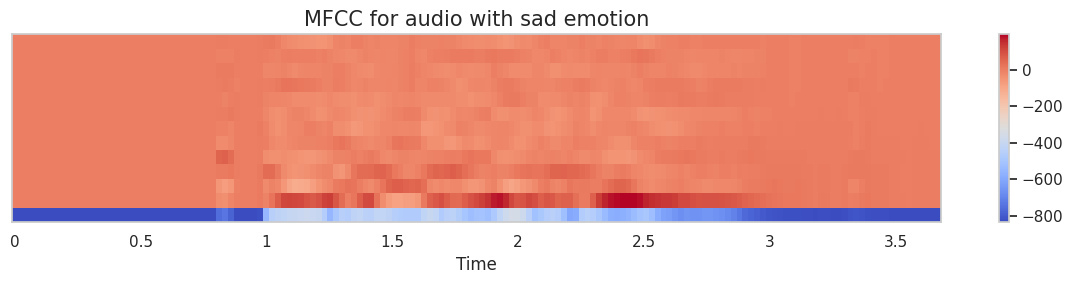

In [21]:
# Emotion : Sad
emotion='sad'
path = np.array(data_df.Path[data_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mel_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

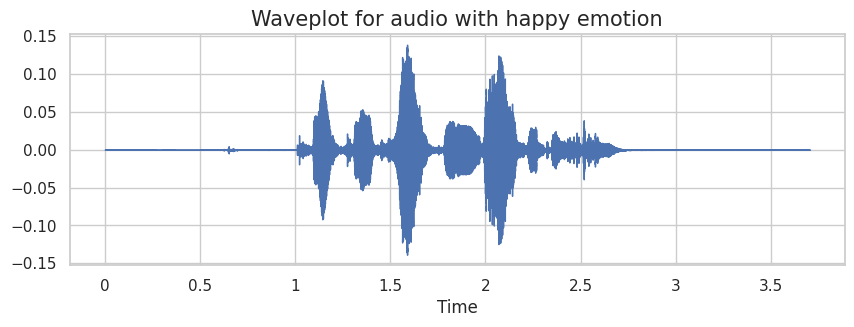

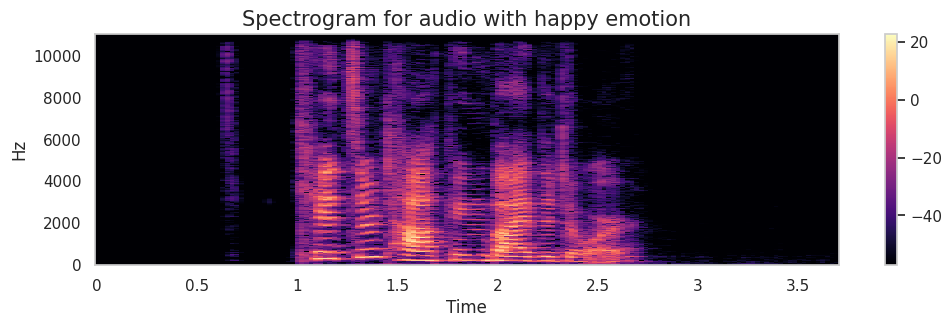

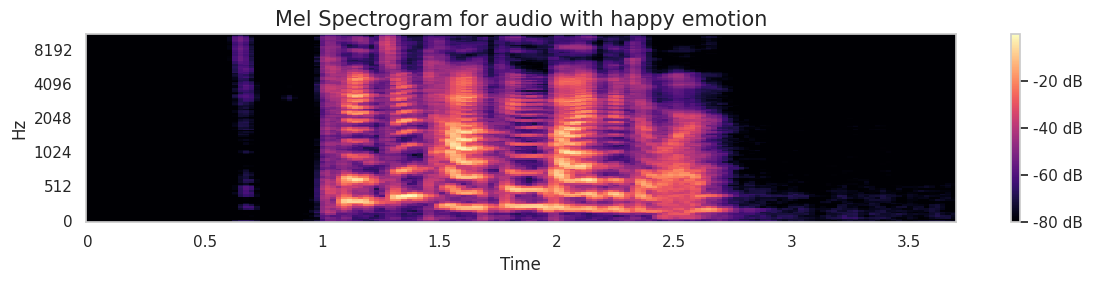

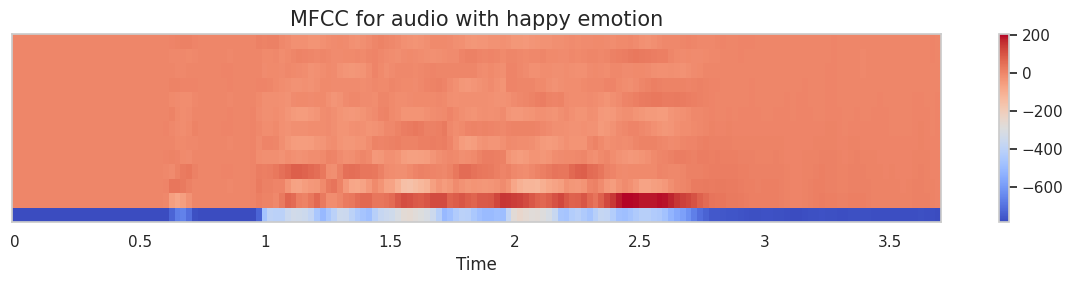

In [22]:
# Emotion : Happy
emotion='happy'
path = np.array(data_df.Path[data_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mel_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

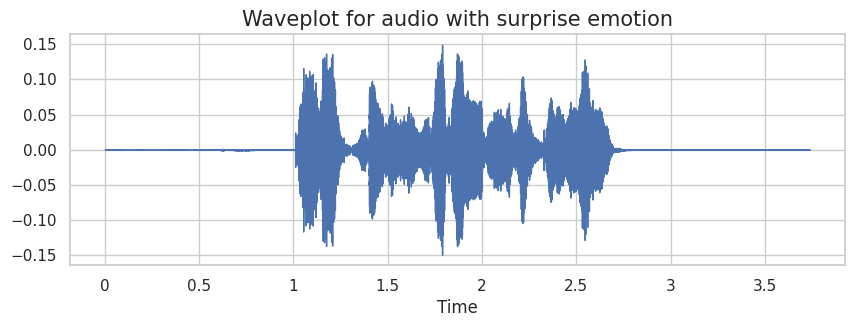

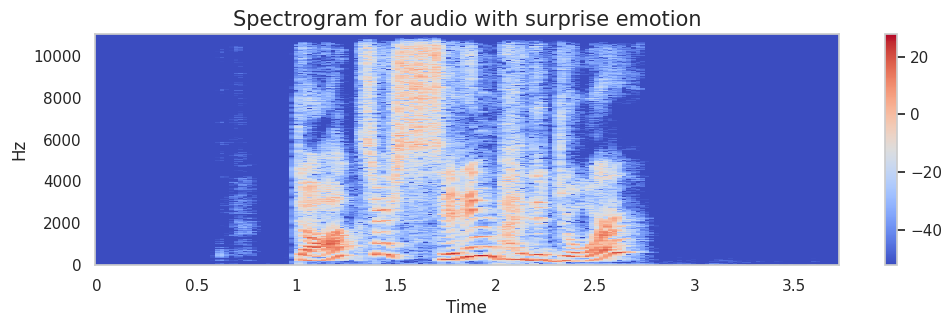

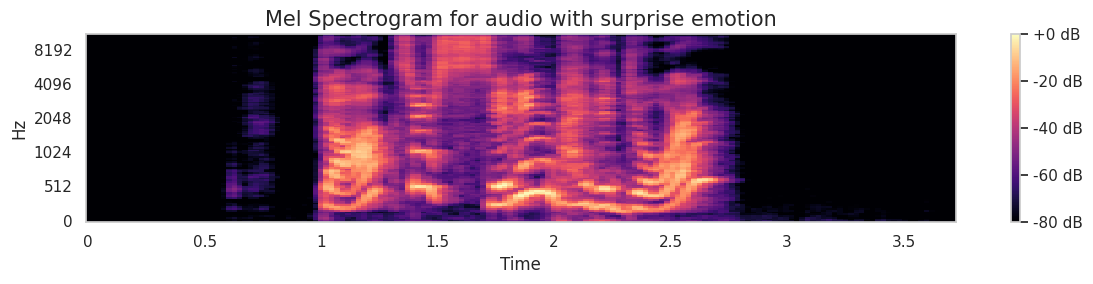

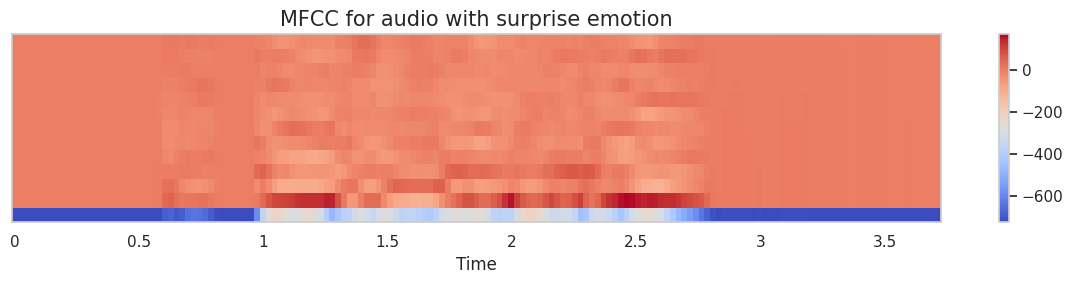

In [23]:
# Emotion : Surprise
emotion='surprise'
path = np.array(data_df.Path[data_df.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
create_mel_spectrogram(data, sampling_rate, emotion)
create_mfcc(data, sampling_rate, emotion)
Audio(path)

## Phase 2: Data Preparation for Deep Learning

## Data Augmentation¶
* Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
* To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
* The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
* In order to this to work adding the perturbations must conserve the same label as the original training sample.
* In images data augmention can be performed by shifting the image, zooming, rotating ...
First, let's check which augmentation techniques works better for our dataset.

In [24]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# Load audio
path = np.array(data_df.Path[data_df.Emotions=='happy'])[1]  # example emotion
data, sample_rate = librosa.load(path)

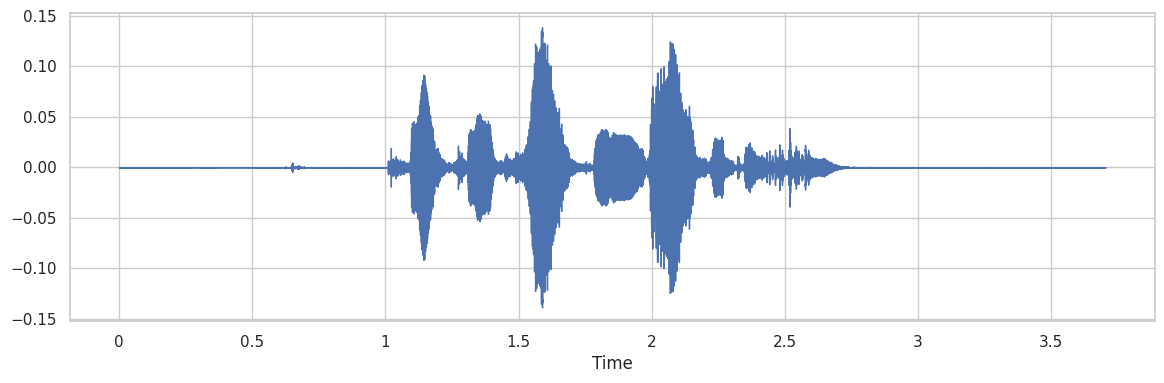

In [25]:
# 1. Simple Audio
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

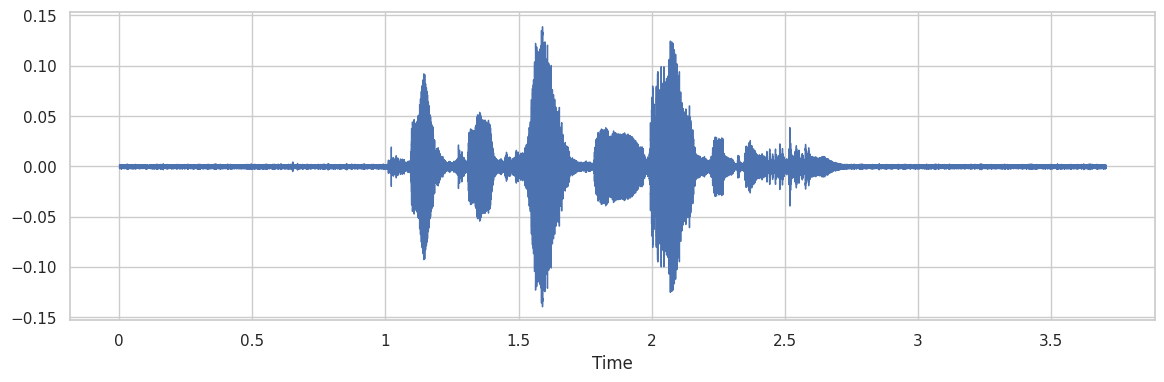

In [26]:
# Noise Injection
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

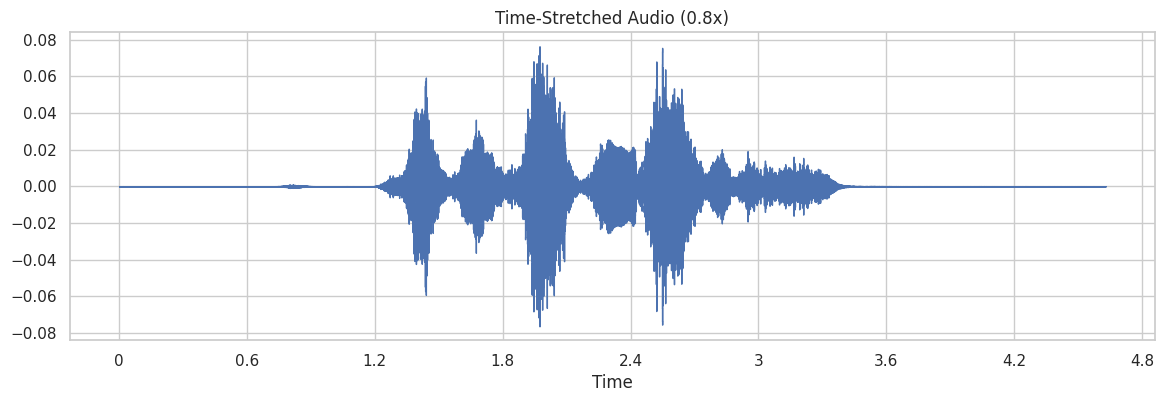

In [27]:
# 3. Stretching
# Define stretching function
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

# Apply time-stretch
x = stretch(data, rate=0.8)

# Plot the wave
plt.figure(figsize=(14, 4))
librosa.display.waveshow(x, sr=sample_rate)
plt.title("Time-Stretched Audio (0.8x)")
plt.show()

# Play the audio
Audio(x, rate=sample_rate)

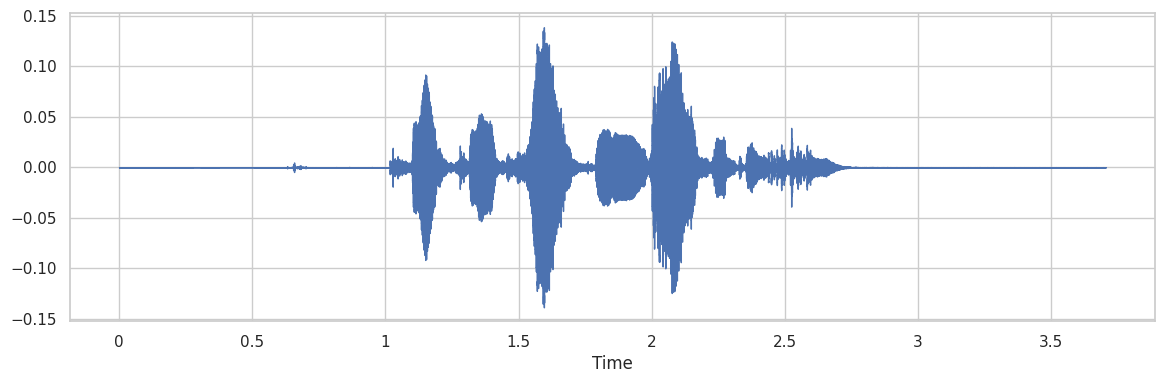

In [28]:
# 4. Shifting
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

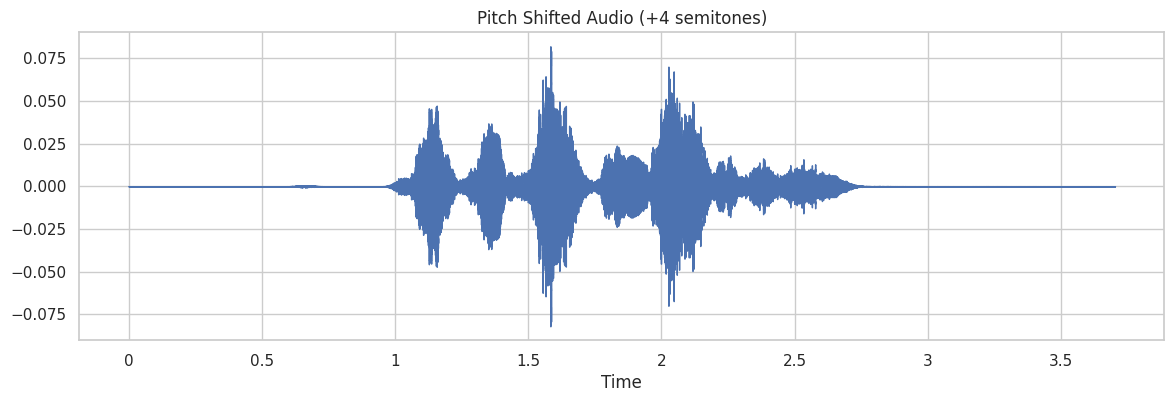

In [29]:
# 5. Pitch
# Define pitch shifting function
def pitch(data, sr, n_steps=4):  # n_steps can be positive (higher pitch) or negative (lower)
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=n_steps)

# Apply pitch shifting
x = pitch(data, sample_rate, n_steps=4)

# Plot the waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(x, sr=sample_rate)  # Use waveshow instead of waveplot (deprecated)
plt.title("Pitch Shifted Audio (+4 semitones)")
plt.show()

# Play the audio
Audio(x, rate=sample_rate)

From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

## Objective: Prepare the audio features in a machine-learning-ready format.
Steps: 
1. Mel Spectrogram Extraction (by 05:00 PM IST): - Use
librosa.feature.melspectrogram() for each audio file. - Normalize the spectrograms
and pad/trim to a fixed size. - Save as 4D tensors with shape: (num_samples, height,
width, 1) for CNN input.

3. Data Splitting (by 06:30 PM IST):

    *  Use sklearn.model_selection.train_test_split().
    *  Suggested split: 80% training, 10% validation, 10% test.
    *  Save the split data using pickle or NumPy arrays.

Deliverables: - Mel spectrograms in 4D tensor format. - Properly split datasets for
training/validation/testing.


In [30]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

In [31]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [32]:
# Assuming 'df' is your full DataFrame
# df = data_df.sample(frac=0.2, random_state=42)

In [36]:
X, Y = [], []
for path, emotion in zip(data_df.Path, data_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [39]:
len(X), len(Y), data_df.Path.shape

(12720, 12720, (4240,))

In [40]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.237382  0.682273  0.670519  0.614793  0.579039  0.566803  0.637206   
1  0.277705  0.687537  0.682005  0.653135  0.639077  0.681255  0.691087   
2  0.206485  0.675004  0.688609  0.712476  0.710047  0.643870  0.597580   
3  0.256113  0.621621  0.580278  0.598515  0.628296  0.598015  0.597272   
4  0.348773  0.718212  0.726202  0.765444  0.792265  0.760102  0.684194   

          7         8         9  ...       153       154       155       156  \
0  0.667451  0.663883  0.669903  ...  0.000234  0.000235  0.000138  0.000128   
1  0.683677  0.661694  0.674044  ...  0.000255  0.000253  0.000159  0.000148   
2  0.552463  0.500956  0.517249  ...  0.000058  0.000037  0.000046  0.000030   
3  0.650352  0.698636  0.681863  ...  0.000018  0.000016  0.000013  0.000012   
4  0.707304  0.743329  0.732374  ...  0.000502  0.000501  0.000504  0.000481   

        157       158       159       160           161    labels  
0  0.000299  0.000360  0.000275  0.000173  2.896729e-05  surprise  
1  0.000322  0.000380  0.000295  0.000196  4.922658e-05  surprise  
2  0.000048  0.000047  0.000057  0.000027  2.675169e-06  surprise  
3  0.000007  0.000008  0.000008  0.000005  5.802852e-07   neutral  
4  0.000431  0.000500  0.000494  0.000502  4.494591e-04   neutral  

[5 rows x 163 columns]

### Data Preparation¶
As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [41]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [42]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [43]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((9540, 162), (9540, 8), (3180, 162), (3180, 8))

In [44]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((9540, 162), (9540, 8), (3180, 162), (3180, 8))

In [45]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((9540, 162, 1), (9540, 8), (3180, 162, 1), (3180, 8))

### Phase 3: Deep Learning Model and Baseline Evaluation
Objective: Build a baseline deep learning model and evaluate its classification
performance.
Steps: 
1. Model Architecture Design (by 07:00 PM IST): - Input: (128x128x1) or
appropriate spectrogram size. - Layers: - Conv1D → MaxPooling → BatchNorm - Repeat
above - Flatten → LSTM layer (to capture time-series dependencies) - Dense (Softmax)
output - Use Keras or PyTorch for implementation.
2. Training (by 09:00 PM IST):
    * Compile with categorical_crossentropy, Adam, and EarlyStopping.
    * Train on GPU (if available) for faster processing.
3. Evaluation (by 10:30 PM IST):
    * Metrics: Accuracy, Confusion Matrix, Precision, Recall, F1-Score.
    * Visuals: Loss curve, Accuracy curve, and Confusion matrix heatmap.
Deliverables: - Trained CNN-LSTM model. - Performance metrics and visualizations.

In [46]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, MaxPooling1D, Conv1D, BatchNormalization, Flatten, LSTM, Dense, TimeDistributed, Reshape
from tensorflow.keras.layers import BatchNormalization

In [48]:
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(162, 1)))
# model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='softmax'))

In [49]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0005)  # You can try different values like 0.001, 0.0003, etc.

In [54]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [55]:
from keras.callbacks import EarlyStopping

# Callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history = model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9615 - loss: 0.1194 - val_accuracy: 0.8491 - val_loss: 0.5418
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9614 - loss: 0.1238 - val_accuracy: 0.8569 - val_loss: 0.5058
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9685 - loss: 0.1084 - val_accuracy: 0.8522 - val_loss: 0.5448
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9720 - loss: 0.0949 - val_accuracy: 0.8658 - val_loss: 0.4891
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9747 - loss: 0.0926 - val_accuracy: 0.8538 - val_loss: 0.5095
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9745 - loss: 0.0813 - val_accuracy: 0.8548 - val_loss: 0.5441
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9818 - loss: 0.0691 - val_accuracy: 0.8679 - val_loss: 0.5037
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9809 - loss: 0.0626 - val_accuracy: 0

In [56]:
#Save model and scaler
model.save('emotion_model.h5')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(encoder, 'encoder.pkl')

['encoder.pkl']

## Key Observations
### Positive Trends (Epochs 1–12):
    * Training accuracy improves significantly from 55.8% → 89.7%
    * Validation accuracy improves steadily from 66.5% → 82.6%
    * Training loss decreases consistently (1.44 → 0.40)
    * Validation loss also decreases from 1.60 → 0.55
    * Interpretation: The model is learning well without overfitting initially.

### Saturation and Overfitting Signs (After Epoch 13):
    * Training accuracy keeps increasing from 90.2% → 93.4%
    * Validation accuracy stays flat (~82.8%) or even slightly decreases
    * Training loss keeps dropping (0.38 → 0.29), but validation loss starts rising again (0.55 → 0.59)

### Interpretation:
    * Model is overfitting after epoch ~13–14. It’s memorizing training data, but not improving on unseen data.

### Final Recommendation
    * Use early stopping around epoch 13–15
    * Best generalization appears around epoch 13 or 15 (validation accuracy peaks ~82.8% and val loss lowest ~0.548)

The model learns efficiently till epoch 13, after which validation performance saturates and signs of overfitting begin — the best stopping point is between epoch 13–15.



In [49]:
# print(history.history.keys())

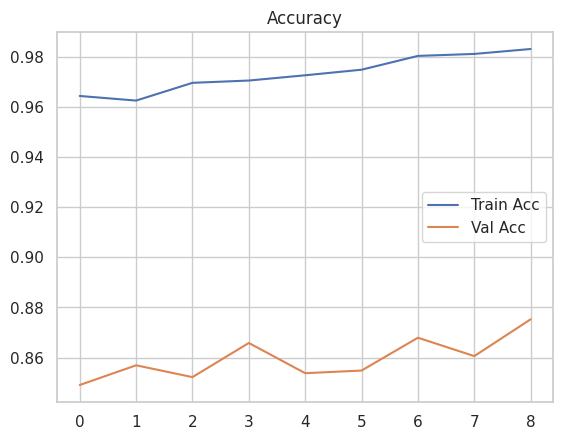

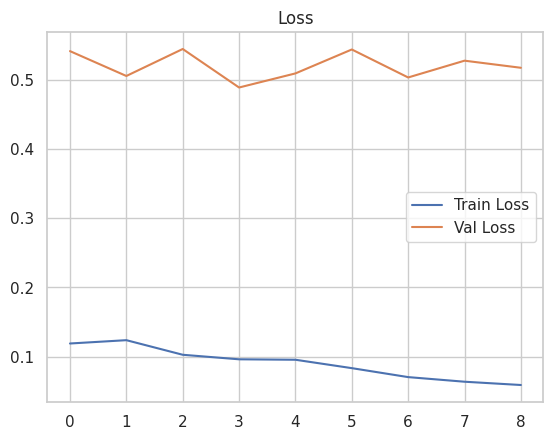

In [57]:
# Accuracy & Loss plots
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy"); plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss"); plt.show()

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


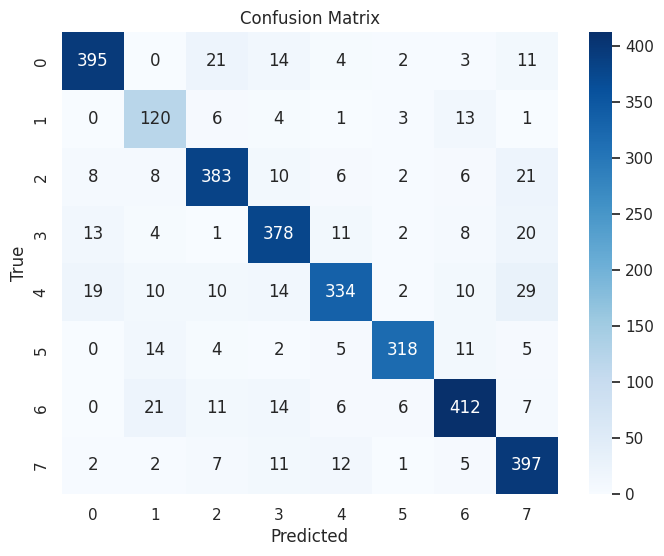

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       450
           1       0.67      0.81      0.73       148
           2       0.86      0.86      0.86       444
           3       0.85      0.86      0.86       437
           4       0.88      0.78      0.83       428
           5       0.95      0.89      0.92       359
           6       0.88      0.86      0.87       477
           7       0.81      0.91      0.86       437

    accuracy                           0.86      3180
   macro avg       0.85      0.86      0.85      3180
weighted avg       0.86      0.86      0.86      3180



In [58]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true_labels, y_pred_labels))


In [59]:
# # predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [60]:
y_test = encoder.inverse_transform(y_test)
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
# The correct way to create the DataFrame:
# df = pd.DataFrame({
#     'Predicted Labels': y_pred.flatten(),
#     'Actual Labels': y_test.flatten()
# })

# # df.head(10)

df.head(10)

Predicted Labels Actual Labels
0          disgust       disgust
1         surprise      surprise
2          neutral           sad
3            happy         happy
4             fear          fear
5             fear          fear
6         surprise      surprise
7            angry         angry
8          disgust       disgust
9          disgust       disgust

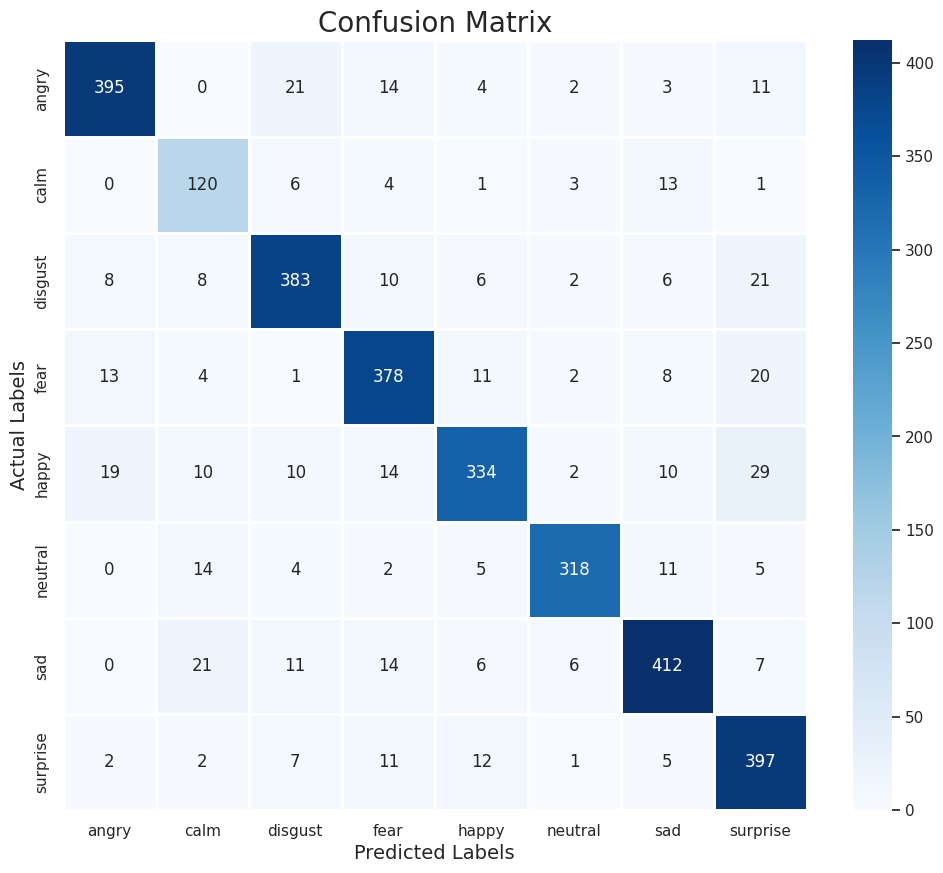

In [61]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.90      0.88      0.89       450
        calm       0.67      0.81      0.73       148
     disgust       0.86      0.86      0.86       444
        fear       0.85      0.86      0.86       437
       happy       0.88      0.78      0.83       428
     neutral       0.95      0.89      0.92       359
         sad       0.88      0.86      0.87       477
    surprise       0.81      0.91      0.86       437

    accuracy                           0.86      3180
   macro avg       0.85      0.86      0.85      3180
weighted avg       0.86      0.86      0.86      3180



## Final Insights:
    * We can see our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc.
    * Our model achieved 80% overall accuracy, performing best on neutral, angry, and surprise emotions. Improvements can be made with advanced augmentation and feature extraction techniques.

### Phase 4: Transition Planning
Objective: Document learnings from Stage 1 and plan for Stage 2.
Steps: 
1. Summarize accomplishments: - Data preprocessing pipeline. - Baseline model
and its performance.
2. Identify limitations:
    * Accuracy gaps
    * Dataset bias
    * Incomplete feature coverage
3. Outline Stage 2 goals:
    * Full dataset training
    * Regression approach for continuous emotion spectrum
    * Uncertainty estimation
    * Interpretability (Grad-CAM